In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the ZIP file here (COVID-19 Radiography Database.zip)


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

zip_path = "archive (1).zip"  # ✅ exact filename with space
extract_dir = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete!")


✅ Extraction complete!


In [ ]:
import os, glob, shutil, random
from pathlib import Path

# Source folders
base_path = "/content/data/COVID-19_Radiography_Dataset"
cov_src = os.path.join(base_path, "COVID")
normal_src = os.path.join(base_path, "Normal")
viral_src = os.path.join(base_path, "Viral Pneumonia")
lung_src = os.path.join(base_path, "Lung_Opacity")

# ✅ Get all images recursively (.png files)
cov_files = glob.glob(os.path.join(cov_src, "**", "*.png"), recursive=True)
normal_files = glob.glob(os.path.join(normal_src, "**", "*.png"), recursive=True)
viral_files = glob.glob(os.path.join(viral_src, "**", "*.png"), recursive=True)
lung_files = glob.glob(os.path.join(lung_src, "**", "*.png"), recursive=True)

# Combine NONCOVID classes
noncov_files = normal_files + viral_files + lung_files

# Target folders
base = Path("/content/dataset")
for split in ["train", "val", "test"]:
    for cls in ["COVID", "NONCOVID"]:
        (base / split / cls).mkdir(parents=True, exist_ok=True)

# Shuffle and balance
random.seed(42)
random.shuffle(cov_files)
random.shuffle(noncov_files)
n = min(len(cov_files), len(noncov_files))
cov_files = cov_files[:n]
noncov_files = noncov_files[:n]

# Split function
def split_and_copy(files, cls):
    n_train = int(0.7 * len(files))
    n_val = int(0.85 * len(files))
    for i, src in enumerate(files):
        dest = base / ("train" if i < n_train else "val" if i < n_val else "test") / cls
        shutil.copy(src, dest / os.path.basename(src))

# Do the split
split_and_copy(cov_files, "COVID")
split_and_copy(noncov_files, "NONCOVID")

print("✅ Dataset ready!")
print("Train COVID:", len(os.listdir(base/'train'/'COVID')))
print("Train NONCOVID:", len(os.listdir(base/'train'/'NONCOVID')))
print("Val COVID:", len(os.listdir(base/'val'/'COVID')))
print("Test COVID:", len(os.listdir(base/'test'/'COVID')))


✅ Dataset ready!
Train COVID: 3272
Train NONCOVID: 4692
Val COVID: 999
Test COVID: 1006


In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data transforms (resize + normalize for ResNet-18)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageFolder("/content/dataset/train", transform=train_transform)
val_dataset   = ImageFolder("/content/dataset/val", transform=val_test_transform)
test_dataset  = ImageFolder("/content/dataset/test", transform=val_test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Data loaders ready!")
print("Classes:", train_dataset.classes)
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


✅ Data loaders ready!
Classes: ['COVID', 'NONCOVID']
Train batches: 249
Val batches: 65
Test batches: 65


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True  # fine-tune all layers

# Replace final FC layer (512 → 2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5   # you can increase to 10-15 later
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_resnet18.pth")

print("✅ Training complete. Best Val Acc:", best_acc)


Using device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


Epoch [1/5] | Loss: 0.4514 | Val Acc: 79.48%


Epoch [2/5] | Loss: 0.3485 | Val Acc: 83.57%


Epoch [3/5] | Loss: 0.3098 | Val Acc: 80.44%


Epoch [4/5] | Loss: 0.2931 | Val Acc: 84.10%


Epoch [5/5] | Loss: 0.2819 | Val Acc: 84.44%
✅ Training complete. Best Val Acc: 84.4412331406551


✅ Classification Report:

              precision    recall  f1-score   support

       COVID       0.83      0.85      0.84      1006
    NONCOVID       0.86      0.84      0.85      1068

    accuracy                           0.84      2074
   macro avg       0.84      0.84      0.84      2074
weighted avg       0.84      0.84      0.84      2074



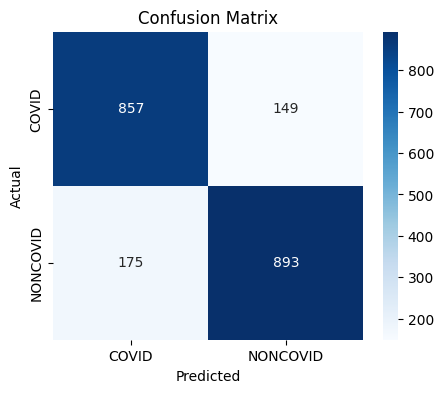

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_resnet18.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("✅ Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["COVID", "NONCOVID"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["COVID","NONCOVID"], yticklabels=["COVID","NONCOVID"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


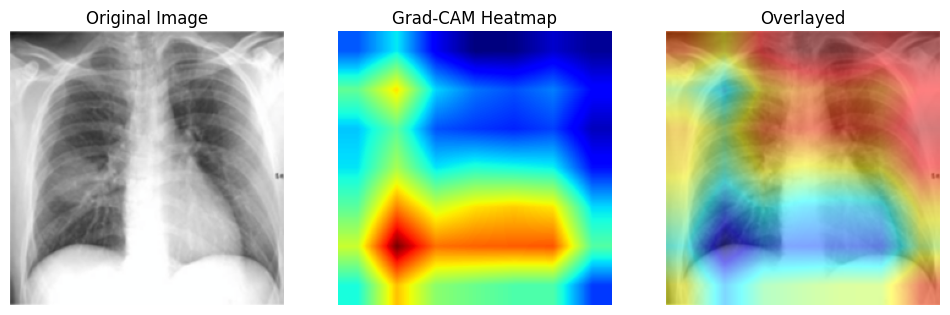

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to get Grad-CAM
def generate_gradcam(model, image, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    model.eval()
    image = image.unsqueeze(0).to(device)
    output = model(image)
    pred_class = output.argmax(dim=1)
    loss = output[0, pred_class]
    model.zero_grad()
    loss.backward()

    # Process Grad-CAM
    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

# Pick one test image
test_iter = iter(test_loader)
images, labels = next(test_iter)
img = images[0]
label = labels[0]

# Get Grad-CAM from last conv layer
target_layer = model.layer4[1].conv2
cam = generate_gradcam(model, img, target_layer)

# Convert image for display
np_img = img.permute(1, 2, 0).cpu().numpy()
np_img = np.clip((np_img * [0.229,0.224,0.225]) + [0.485,0.456,0.406], 0, 1)

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(np_img)
overlay = overlay / np.max(overlay)

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original Image"); plt.imshow(np_img); plt.axis('off')
plt.subplot(1,3,2); plt.title("Grad-CAM Heatmap"); plt.imshow(cam, cmap='jet'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlayed"); plt.imshow(overlay); plt.axis('off')
plt.show()


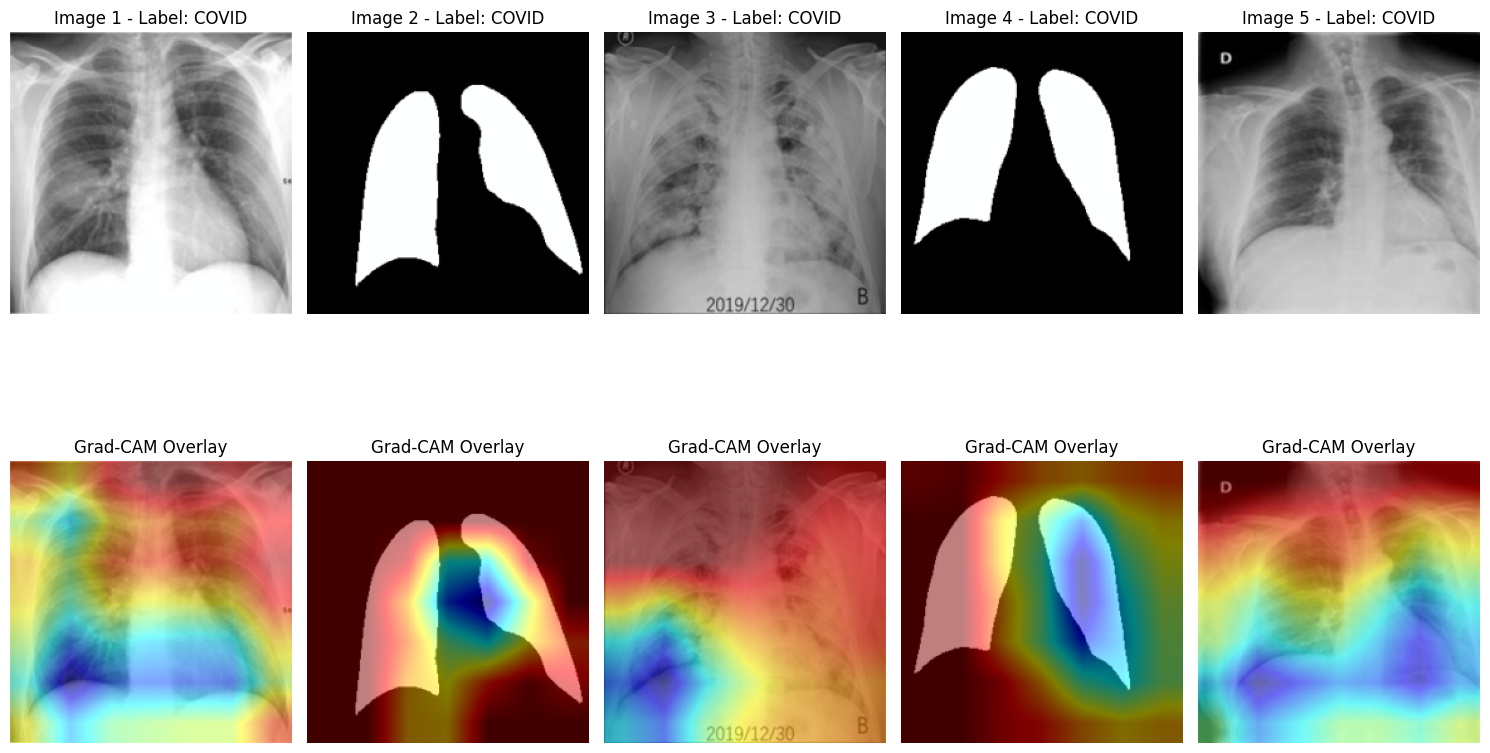

In [ ]:
# Grad-CAM for 5 test images
fig = plt.figure(figsize=(15, 10))
model.eval()

for i in range(5):
    img = images[i]
    label = labels[i]

    cam = generate_gradcam(model, img, target_layer)

    # Convert image back to normal
    np_img = img.permute(1, 2, 0).cpu().numpy()
    np_img = np.clip((np_img * [0.229,0.224,0.225]) + [0.485,0.456,0.406], 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) / 255.0
    overlay = heatmap + np_img
    overlay = overlay / overlay.max()

    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np_img)
    ax.set_title(f"Image {i+1} - Label: {'COVID' if label==0 else 'NONCOVID'}")
    ax.axis('off')

    ax = fig.add_subplot(2, 5, i + 6)
    ax.imshow(overlay)
    ax.set_title("Grad-CAM Overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [3]:
!find / -name "*.ipynb" 2>/dev/null | grep -i "ML"


/usr/local/lib/python3.12/dist-packages/holoviews/examples/gallery/demos/bokeh/html_hover_tooltips.ipynb
/usr/local/lib/python3.12/dist-packages/cuml/experimental/hyperparams/HPO_demo.ipynb
